Function ij_agent_simulation_goal_unknown_gf1 does the following, and takes as input all variables mentioned below.

Let there be a grid of grid_rows rows and grid_columns columns. Each cell in the grid is a position that an agent can find themselves in. There is an agent X. In the first time step, X is in the first cell of the grid, in the upper left corner, cell with coordinates (1,1). Agent has reached their goal when it is the last cell of the grid with coordinates (grid_rows, grid_columns). 

The governance framework G1 includes the following rules:
1. The grid is divided into 4 parts, obtained by dividing the grid in half horizontally and vertically. Each part has the same number of cells. 
2. Label each part of the grid with a number from 1 to 4. 
3. Randomly order the labels of grid parts.
4. In the given order of grid parts, direct the agent to move to the first cell of the grid part, which is the upper left corner cell of the grid part. 
5. Once the agent is in the first cell of the grid part, direct the agent to traverse all cells in the grid part, without revisiting a cell. 
6. If the agent reached the goal cell, stop. If the agent traversed all cells in the grid part and did not reach the goal cell, then direct the agent to move to the first cell of the next grid part.

Agent X obeys the governance framework.

Run the simulation run_count times, print print the average number of time steps across all runs, print the standard deviation of the number of steps across all runs, print the histogram of number of steps across runs (histogram bars should have color #FF003C), and if make_images is 1 then for each run, do the following:
1. create svg image using drawsvg and the corresponding png image, both images have the same filename
2. create a text file which records the python script of the function and the values of all variables passed to the function, such that the text file has the same filename as the images
3. the filename has the following format: "ivanjureta_com_agent_walk_" followed by the current date in the format YYYYMMDD, followed by an underscore, followed by a six digit random number, followed by two underscores, followed by the number of the run
4. the text file shows the number of time steps it took the agent to reach the goal, and includes a list of the coordinates of cells on the agent's path, in the sequence that the agent moved across these cells, and ends with the total number of steps the agent took in the run
5. the image is image_width pixels wide and image_height pixels high 
6. image background is filled with color image_background_color 
7. the image is filled with a grid that has grid_rows rows and grid_columns columns, in which each cell has an edge that is grid_edge_thickness pixels wide, and the edge is colored in grid_edge_color 
8. in the center of each cell of the grid is a square whose side is path_thickness pixels long, the square is filled with color grid_center_color
9. in each cell the agent visited, print the total number of times the agent visited that cell, color the numbers in step_number_color, use the font 'Noto Sans' to print numbers
10. in each cell that the agent visited, draw a circle as wide as the cell and fill it with color path_cell_color in such a way that the transparency of the color increases with the number of times the agent visited that cell (for transparency, use alpha, not opacity)
11. for any two cells in the grid, if the agent moved from one to the other, draw a line that is path_thickness pixels pixels wide and connects the centers of the two cells; if the agent moved between these cells multiple times during the simulation run, draw only one line
12. output the svg and png images, the text file, and a table which shows the number

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import drawsvg as draw
from datetime import datetime
import os
import json
import cairosvg

def ij_agent_simulation_goal_unknown_gf1(grid_rows, grid_columns, run_count, make_images, image_width, image_height, 
                                         image_background_color, grid_edge_thickness, grid_edge_color, path_thickness, 
                                         grid_center_color, step_number_color, path_cell_color):
    # Helper function to split the grid into four parts
    def get_grid_parts(rows, columns):
        mid_row = rows // 2
        mid_column = columns // 2
        return {
            1: [(i, j) for i in range(1, mid_row + 1) for j in range(1, mid_column + 1)],
            2: [(i, j) for i in range(1, mid_row + 1) for j in range(mid_column + 1, columns + 1)],
            3: [(i, j) for i in range(mid_row + 1, rows + 1) for j in range(1, mid_column + 1)],
            4: [(i, j) for i in range(mid_row + 1, rows + 1) for j in range(mid_column + 1, columns + 1)],
        }
    
    # Helper function to traverse cells within a grid part
    def traverse_grid_part(agent_path, grid_part, visited, goal_cell):
        for cell in grid_part:
            if cell not in visited:
                agent_path.append(cell)
                visited.add(cell)
            if cell == goal_cell:
                return True
        return False

    # Run the simulation multiple times
    steps_list = []
    all_paths = []
    goal_cell = (grid_rows, grid_columns)
    
    for run in range(run_count):
        agent_position = (1, 1)
        visited = set()
        visited.add(agent_position)
        agent_path = [agent_position]
        
        grid_parts = get_grid_parts(grid_rows, grid_columns)
        part_order = list(grid_parts.keys())
        random.shuffle(part_order)
        
        # Traverse the grid parts in random order
        for part_num in part_order:
            grid_part = grid_parts[part_num]
            if traverse_grid_part(agent_path, grid_part, visited, goal_cell):
                break
        
        steps_list.append(len(agent_path))
        all_paths.append(agent_path)
        
        # Create images if required
        if make_images == 1:
            date_str = datetime.now().strftime("%Y%m%d")
            random_number = random.randint(100000, 999999)
            filename_base = f"ivanjureta_com_agent_walk_{date_str}_{random_number:06d}__{run + 1}"
            
            # Draw the grid and path using drawsvg
            d = draw.Drawing(image_width, image_height, origin='center', displayInline=False)
            d.append(draw.Rectangle(-image_width // 2, -image_height // 2, image_width, image_height, 
                                    fill=image_background_color))
            
            cell_width = image_width / grid_columns
            cell_height = image_height / grid_rows
            
            # Draw grid edges
            for i in range(grid_rows):
                for j in range(grid_columns):
                    x = -image_width // 2 + j * cell_width
                    y = -image_height // 2 + i * cell_height
                    d.append(draw.Rectangle(x, y, cell_width, cell_height, 
                                            stroke=grid_edge_color, stroke_width=grid_edge_thickness, fill='none'))
                    # Draw center square in each cell
                    center_x = x + cell_width / 2 - path_thickness / 2
                    center_y = y + cell_height / 2 - path_thickness / 2
                    d.append(draw.Rectangle(center_x, center_y, path_thickness, path_thickness, 
                                            fill=grid_center_color))
            
            # Draw the agent's path
            cell_visit_count = {}
            for step, (i, j) in enumerate(agent_path):
                cell_visit_count[(i, j)] = cell_visit_count.get((i, j), 0) + 1
                x = -image_width // 2 + (j - 1) * cell_width
                y = -image_height // 2 + (i - 1) * cell_height
                alpha = min(1.0, 0.1 * cell_visit_count[(i, j)])
                d.append(draw.Circle(x + cell_width / 2, y + cell_height / 2, min(cell_width, cell_height) / 2,
                                     fill=path_cell_color, fill_opacity=alpha))
                d.append(draw.Text(str(cell_visit_count[(i, j)]), 10, x + cell_width / 2, y + cell_height / 2,
                                   fill=step_number_color, font_family='Noto Sans', center=True))
            
            # Draw lines between cells for agent's path
            for k in range(1, len(agent_path)):
                x1 = -image_width // 2 + (agent_path[k - 1][1] - 1) * cell_width + cell_width / 2
                y1 = -image_height // 2 + (agent_path[k - 1][0] - 1) * cell_height + cell_height / 2
                x2 = -image_width // 2 + (agent_path[k][1] - 1) * cell_width + cell_width / 2
                y2 = -image_height // 2 + (agent_path[k][0] - 1) * cell_height + cell_height / 2
                d.append(draw.Line(x1, y1, x2, y2, stroke=path_cell_color, stroke_width=path_thickness))
            
            # Save SVG and PNG images
            svg_filename = f"{filename_base}.svg"
            png_filename = f"{filename_base}.png"
            d.save_svg(svg_filename)
            cairosvg.svg2png(url=svg_filename, write_to=png_filename)
            
            # Save the text file
            with open(f"{filename_base}.txt", 'w') as f:
                f.write(f"Function: ij_agent_simulation_goal_unknown_gf1\n")
                f.write(f"Run Number: {run + 1}\n")
                f.write(f"Grid Size: {grid_rows}x{grid_columns}\n")
                f.write(f"Total Steps: {len(agent_path)}\n")
                f.write(f"Path:\n")
                json.dump(agent_path, f)
    
    # Print statistics
    avg_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    print(f"Average Number of Steps: {avg_steps}")
    print(f"Standard Deviation of Steps: {std_steps}")
    
    # Plot histogram of steps
    plt.hist(steps_list, bins=10, color='#FF003C', alpha=0.7)
    plt.xlabel('Number of Steps')
    plt.ylabel('Frequency')
    plt.title('Histogram of Number of Steps Across Runs')
    plt.show()


Average Number of Steps: 480.6
Standard Deviation of Steps: 203.52945732743453


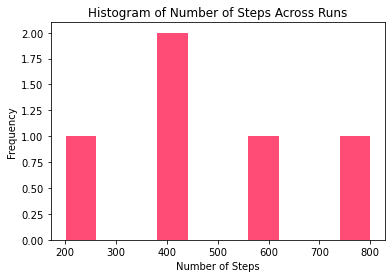

In [2]:
# Simulate agent's decisions, five runs only and make images to show agent's decisions
# Be careful when setting make_images: if 1, then the number of output files will be 3 * run_count 
ij_agent_simulation_goal_unknown_gf1(
    grid_rows=20, 
    grid_columns=40, 
    run_count=5, 
    image_width=2000, 
    image_height=1000, 
    image_background_color='none', 
    make_images = 1,
    grid_edge_thickness=0, 
    grid_edge_color='none', 
    path_thickness=3, 
    grid_center_color='#cccccc', 
    path_cell_color='#FF003C',  
    step_number_color='#ffffff'
)

Average Number of Steps: 495.0516
Standard Deviation of Steps: 223.39728050591842


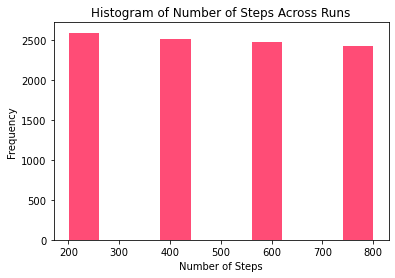

In [3]:
# Simulate agent's decisions, 10000 runs without making images
# Be careful when setting make_images: if 1, then the number of output files will be 3 * run_count 
ij_agent_simulation_goal_unknown_gf1(
    grid_rows=20, 
    grid_columns=40, 
    run_count=10000, 
    image_width=2000, 
    image_height=1000, 
    image_background_color='none', 
    make_images = 0,
    grid_edge_thickness=0, 
    grid_edge_color='none', 
    path_thickness=3, 
    grid_center_color='#cccccc', 
    path_cell_color='#FF003C',  
    step_number_color='#ffffff'
)